In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
plt.style.use('dark_background')

In [83]:
base_dir = '/data/severstal-steel-defect-detection/'
train_df = pd.read_csv(base_dir+'/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [84]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [110]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if rle:
                masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [111]:
def read_image(imageId):
    sample_image_df = train_df[train_df['ImageId'] == imageId]
    sample_path = base_dir+"train_images/{}".format(sample_image_df['ImageId'].iloc[0])
    sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    sample_rles = sample_image_df['EncodedPixels'].values
    sample_masks = build_masks(sample_rles, input_shape=(256, 1600))
    
    return sample_img, sample_masks

In [112]:
def get_segment(start_width, start_height, segment_width, segment_height, sample_img, sample_masks):
    """
    Get a rectangular segment from the image
    """
    
    # throw error if trying to retrieve a segment outside the bounds of the image
    if start_width + segment_width > sample_img.shape[1]:
        raise IndexError("width inputs exceed image size (start_width: {}, segment_width: {}, image_width: {}, OVER_BY: {})".format(start_width, segment_width, sample_img.shape[1], start_width+segment_width-sample_img.shape[1]))
    elif start_height + segment_height > sample_img.shape[0]:
        raise IndexError("height inputs exceed image size (start_height: {}, segment_height: {}, image_height: {}, OVER_BY: {})".format(start_height, segment_height, sample_img.shape[0], start_height+segment_height-sample_img.shape[0]))
    
    return sample_img[start_height:start_height+segment_height, start_width:start_width+segment_width], sample_masks[start_height:start_height+segment_height, start_width:start_width+segment_width,:]
    

In [113]:
def show_images(image, masks):
    """
    
    """
    
    fig, axs = plt.subplots(5, figsize=(12, 12))
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Raw')

    for i in range(4):
        axs[i+1].imshow(masks[:, :, i])
        axs[i+1].axis('off')
        axs[i+1].set_title('Defect {}'.format(i+1))

In [114]:
img, masks = read_image(train_df.ImageId.values[0])

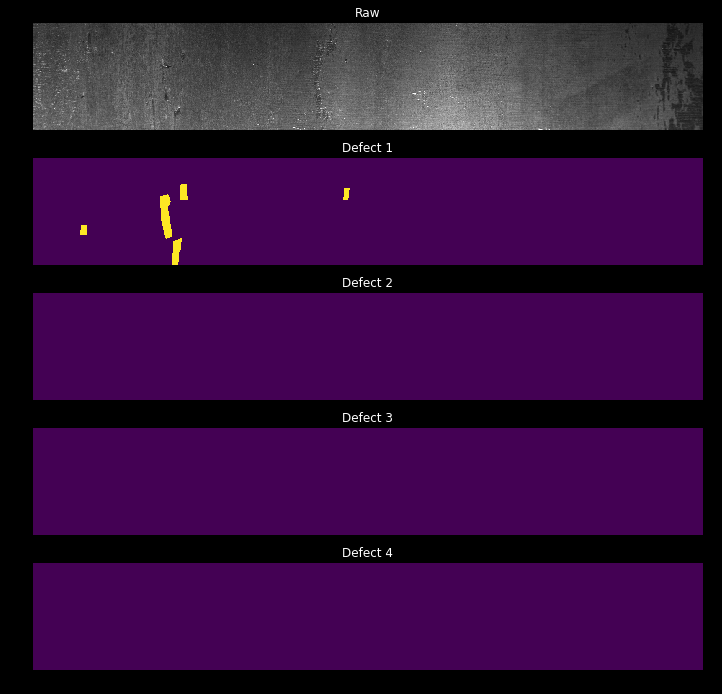

In [115]:
show_images(img,masks)

In [116]:
segment_img, segment_masks = get_segment(0, 0, 500, 100, img, masks)

In [117]:
segment_masks.sum(axis=0).sum(axis=0)

array([810.,   0.,   0.,   0.])

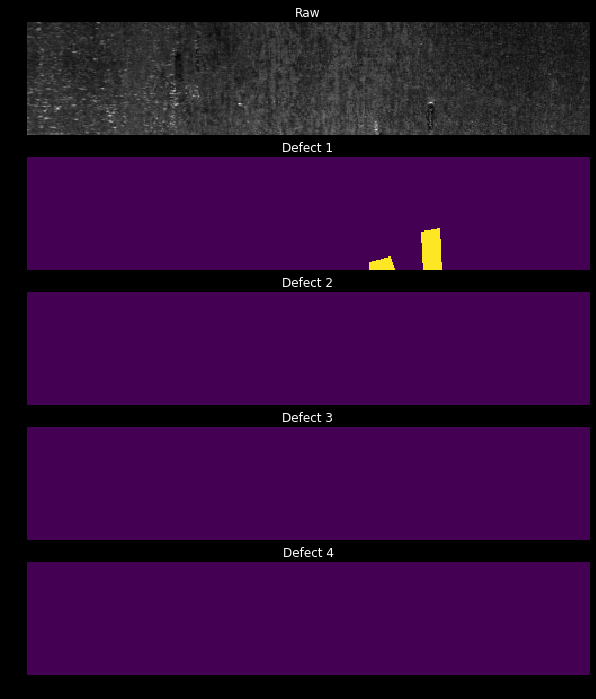

In [118]:
show_images(segment_img, segment_masks)

In [119]:
def split_image(imageId, segment_width=256, segment_height=256, width_step=32, height_step=32, rotate_horizontal=False, rotate_vertical=False):
    
    img, masks = read_image(imageId)
    
    img_height, img_width  = img.shape

    to_return = []

    for h in range(0, img_height, height_step):
        for w in range(0, img_width, width_step):

            if w + segment_width > img_width:
                continue
            elif h + segment_height > img_height:
                continue

            segment_img, segment_masks = get_segment(w, h, segment_width, segment_height, img, masks)

            defect_pixel_counts = segment_masks.sum(axis=0).sum(axis=0).astype(int)
            classes_present = np.sum(defect_pixel_counts>0)

#             for d, dpc in enumerate(defect_pixel_counts):
#                 to_return.append([imageId, w, h, segment_width, segment_height, d+1, dpc, classes_present, mask2rle(segment_masks[:,:,d])])
            to_return.append(['{}_{}_{}_{}_{}'.format(imageId, w, h, segment_width, segment_height), imageId, w, h, segment_width, segment_height, classes_present, defect_pixel_counts.sum()] + list(defect_pixel_counts) + [mask2rle(segment_masks[:,:,d]) for d in range(4)])   
            
    return pd.DataFrame(to_return, 
                        columns = ['Key', 'ImageId','start_width', 'start_height', 'segment_width', 'segment_height','ClassesPresent','DefectedPixels_Total']+ \
                        ['DefectPixels_{}'.format(d) for d in range(1,5)]+ \
                        ['EncodedPixels_{}'.format(d) for d in range(1,5)]
                       )
            

In [120]:
train_df[train_df.ImageId==train_df.ImageId.values[0]]

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False


In [121]:
tmp = split_image(train_df.ImageId.values[0])

In [123]:
tmp.head()

,Key,ImageId,start_width,start_height,segment_width,segment_height,ClassesPresent,DefectedPixels_Total,DefectPixels_1,DefectPixels_2,DefectPixels_3,DefectPixels_4,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
0,0002cc93b.jpg_0_0_256_256,0002cc93b.jpg,0,0,256,256,1,341,341,0,0,0,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,0002cc93b.jpg_32_0_256_256,0002cc93b.jpg,32,0,256,256,1,341,341,0,0,0,20910 12 21154 24 21410 24 21666 24 21922 24 2...,,,
2,0002cc93b.jpg_64_0_256_256,0002cc93b.jpg,64,0,256,256,1,1627,1627,0,0,0,12718 12 12962 24 13218 24 13474 24 13730 24 1...,,,
3,0002cc93b.jpg_96_0_256_256,0002cc93b.jpg,96,0,256,256,1,3373,3373,0,0,0,4526 12 4770 24 5026 24 5282 24 5538 24 5794 2...,,,
4,0002cc93b.jpg_128_0_256_256,0002cc93b.jpg,128,0,256,256,1,3705,3705,0,0,0,45150 27 45406 55 45661 60 45917 64 46173 68 4...,,,


In [124]:
def read_segment(key, segment_df, train=True):
    
    imageId, start_width, start_height, segment_width, segment_height = key.split('_')
    path = '{}{}_images/{}'.format(base_dir, 'train' if train else 'test', imageId)
    
    row = segment_df[segment_df.Key == key]
    
    if row.shape[0]<1:
        raise Exception('Key not found in dataframe')
    
    start_width, start_height, segment_width, segment_height = int(start_width), int(start_height), int(segment_width), int(segment_height)
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    img = img[start_height:start_height+segment_height, start_width:start_width+segment_width]
    
    if train:
        masks = build_masks(row[['EncodedPixels_{}'.format(d) for d in range(1,5)]].values[0], (segment_height, segment_width))
    else:
        masks = None
    
    return img, masks

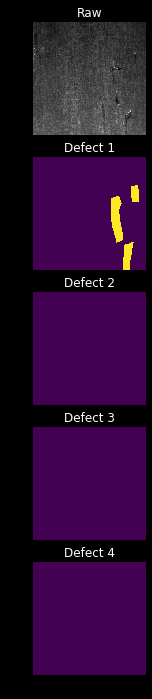

In [128]:
show_images(tmp_img, tmp_masks)